In [3]:
import os
import glob
import numpy as np
import pandas as pd
import geopandas as gpd
import matplotlib.pyplot as plt
# import plotly #allows interactive plotting
import contextily as ctx # back ground maps
import rasterio
import shapely

In [4]:
doc_dir = os.getcwd()
while os.path.basename(doc_dir) != 'Documents':
    doc_dir = os.path.dirname(doc_dir)
# dir of all gwfm data
gwfm_dir = os.path.dirname(doc_dir)+'/Box/research_cosumnes/GWFlowModel'
# dir of stream level data for seepage study
lvl_dir = gwfm_dir + '/Stream_seepage/Stream_level_data'


# Quick Map of Loggers

<AxesSubplot:>

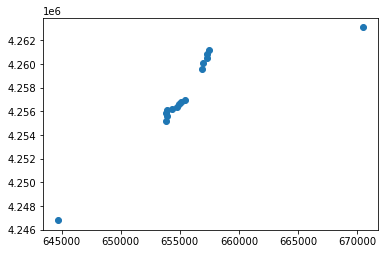

In [8]:
df = pd.read_csv(lvl_dir+'/instream_sensor_latlong.csv')
rm_sp = gpd.GeoDataFrame(df, geometry=gpd.points_from_xy(df.Longitude,df.Latitude))
rm_sp.crs = 'epsg:4326'
rm_sp = rm_sp.to_crs('epsg:32610')

fig, ax =plt.subplots(figsize=(6,6))
rm_sp.plot(ax=ax)
# USGS. USImagery, USImageryTopo, USTopo; Esri. WorldImagery, WorldTopoMap
# ctx.add_basemap(ax=ax, source=ctx.providers.Esri.WorldImagery, crs='epsg:26910', attribution=False)


# Import data files from WY2020

Read in first streamlevel file to create structure for dataframe

In [9]:
def clean_strm_lvl(filename):
    """ cleaning funtioning for levelogger data/column headers where data starts in the 14th row
    Uses file name to rename level column"""
    strmlvl = pd.read_csv(filename,skiprows=13, usecols = ['Date','Time', 'LEVEL', 'TEMPERATURE'], encoding_errors='ignore')
    strmlvl['dt'] = pd.to_datetime(strmlvl.Date+' '+strmlvl.Time)
    strmlvl = strmlvl.set_index('dt').drop(['Date','Time'],axis = 1)
    site_nam = str.split(os.path.basename(filename),'_')[0]
    strmlvl = strmlvl.melt(ignore_index=False,var_name='param', value_vars=['LEVEL','TEMPERATURE'])
    strmlvl['site_nam'] = site_nam
#     strmlvl = strmlvl.rename(columns = {'LEVEL':site_nam})
    strmlvl = strmlvl.sort_index()
#     strmlvl = strmlvl.resample('15min').mean()
    return(strmlvl)


Read in stream level data from WY2020 and join all sites together by time

In [10]:
files = glob.glob(lvl_dir+'/stream_level*/*.csv')
# files = glob.glob(lvl_dir+'/stream_level_2020_11_19/*.csv')

streamlevel = clean_strm_lvl(files[0])
for i in np.arange(1,len(files)):
    temp = clean_strm_lvl(files[i])
#     streamlevel_2020 = streamlevel_2020.join(temp, on = 'dt', how = 'inner')
    streamlevel = streamlevel.append(temp)
#     streamlevel = pd.merge(streamlevel, temp, on = 'dt', how = 'inner')

C:\Users\ajcalder\AppData\Local\Temp\ipykernel_15504\1518200529.py:8: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  streamlevel = streamlevel.append(temp)
C:\Users\ajcalder\AppData\Local\Temp\ipykernel_15504\1518200529.py:8: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  streamlevel = streamlevel.append(temp)
C:\Users\ajcalder\AppData\Local\Temp\ipykernel_15504\1518200529.py:8: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  streamlevel = streamlevel.append(temp)
C:\Users\ajcalder\AppData\Local\Temp\ipykernel_15504\1518200529.py:8: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  streamlevel = streamlevel.append(temp)
C:\Users\ajcalder\AppDat

ValueError: Usecols do not match columns, columns expected but not found: ['LEVEL', 'Time', 'Date', 'TEMPERATURE']

In [ ]:
# save joined streamlevel data to csv for easier use
streamlevel.to_csv(lvl_dir+'/Stream_level_m_temp_C_long.csv')

In [ ]:
streamtemp_out = streamlevel[streamlevel.param=='TEMPERATURE']
streamlevel_out = streamlevel[streamlevel.param=='LEVEL']

In [ ]:
streamtemp_out = streamtemp_out.pivot_table(values='value',columns='site_nam',index='dt')
streamlevel_out = streamlevel_out.pivot_table(values='value',columns='site_nam',index='dt')

In [ ]:
# RM: 2,4,6,8 need to have 9.5m subtracted, some leveloggers have this setting others don't
if streamlevel_out.iloc[0,:].loc[['RM2','RM4','RM6','RM8']].mean()>9.5:
    streamlevel_out.loc[:,['RM2','RM4','RM6','RM8']] = streamlevel_out.loc[:,['RM2','RM4','RM6','RM8']]-9.5


In [ ]:
MW_5

In [107]:
files = glob.glob(lvl_dir+'/Baro/*MW5*.csv')
MW_5 = pd.DataFrame()
for i in np.arange(0,len(files)):
    temp = pd.read_csv(files[i], skiprows=13, encoding_errors='ignore', parse_dates=['Date','Time'])
    temp = temp.rename(columns={'Level':'LEVEL'})
    MW_5 = MW_5.append(temp)
MW_5['Level_m'] = MW_5.LEVEL*0.70324961490205
MW_5['LEVEL'] = MW_5.Level_m - 9.5

files = glob.glob(lvl_dir+'/Baro/*CP1*.csv')
MW_CP1 = pd.DataFrame()
for i in np.arange(0,len(files)):
    temp = pd.read_csv(files[i], skiprows=13, encoding_errors='ignore', parse_dates=['Date','Time'])
    temp = temp.rename(columns={'Level':'LEVEL'})
    MW_CP1 = MW_CP1.append(temp)
    

baro = MW_CP1.append(MW_5)[['Time','LEVEL']].set_index('Time')
baro.resample('15min').mean()

,LEVEL
Time,
2022-05-17 00:00:00,0.847135
2022-05-17 00:15:00,0.843323
2022-05-17 00:30:00,0.843378
2022-05-17 00:45:00,0.843388
2022-05-17 01:00:00,0.847460
...,...
2022-05-17 22:45:00,0.841567
2022-05-17 23:00:00,0.845855
2022-05-17 23:15:00,0.842167


In [68]:
# need to compensate with Baro from Oneto-Denier (MW-CP1, MW5)
files = glob.glob(lvl_dir+'/Baro/*.csv')
baro = clean_strm_lvl(files[0])
for i in np.arange(1,len(files)):
    temp = clean_strm_lvl(files[i])
    baro = baro.append(temp)


ValueError: Usecols do not match columns, columns expected but not found: ['TEMPERATURE', 'LEVEL']

<AxesSubplot:xlabel='dt'>

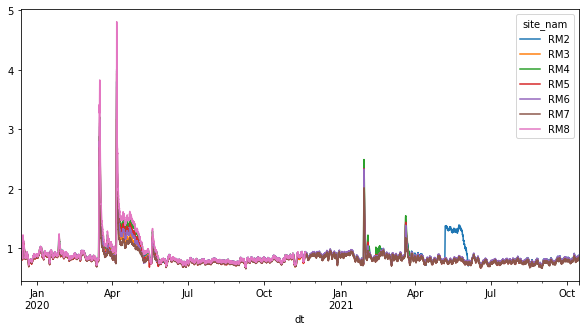

In [64]:
# pd.options.plotting.backend = "plotly"
pd.options.plotting.backend = "matplotlib"

fig, ax = plt.subplots(figsize=(10,5))
streamlevel_out.plot(ax=ax)
# fig.show() # plotly
# fig # mpl

<AxesSubplot:xlabel='dt'>

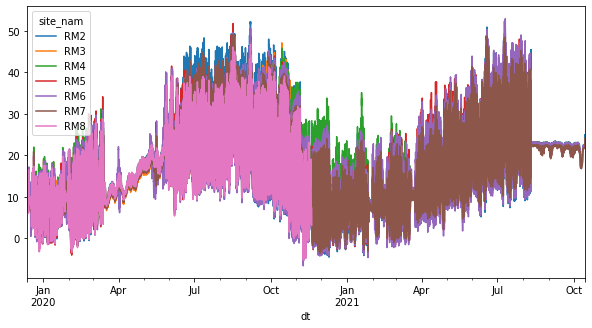

In [65]:
# pd.options.plotting.backend = "plotly"
pd.options.plotting.backend = "matplotlib"

fig, ax = plt.subplots(figsize=(10,5))
streamtemp_out.plot(ax=ax)
# fig.show() # plotly
# fig # mpl